<a href="https://colab.research.google.com/github/R3gm/InsightSolver-Colab/blob/main/Video_Image_Restoration_CodeFormer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<p align="center">
  <img src="https://user-images.githubusercontent.com/14334509/179359809-bd45566a-486d-418f-83fa-67bbbba8c45c.png" height=120>
</p>

# CodeFormer Inference
## Towards Robust Blind Face Restoration with Codebook Lookup Transformer (NeurIPS 2022)
Shangchen Zhou, Kelvin C.K. Chan, Chongyi Li, Chen Change Loy

CodeFormer is a Transformer-based network for robust blind face restoration. It uses a learned discrete codebook to reduce uncertainty in mapping degraded inputs to desired outputs and generate high-quality faces. CodeFormer outperforms existing methods in quality and fidelity, adapting well to different degradation levels.

| Code Credits | Link |
| ----------- | ---- |
| 🎉 Repository | [![GitHub Repository](https://img.shields.io/github/stars/sczhou/CodeFormer?style=social)](https://github.com/sczhou/CodeFormer) |
| Original Colab | [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1m52PNveE4PBhYrecj34cnpEeiHcC5LTb?usp=sharing) |
| 🚀 Online inference | [![Hugging Face Spaces](https://img.shields.io/badge/%F0%9F%A4%97%20Hugging%20Face-Spaces-blue)](https://huggingface.co/spaces/sczhou/CodeFormer) |
| 🚀 Online inference | [![Replicate](https://replicate.com/google-research/frame-interpolation/badge)](https://replicate.com/sczhou/codeformer)
 |
| 🔥 Discover More Colab Notebooks | [![GitHub Repository](https://img.shields.io/badge/GitHub-Repository-black?style=flat-square&logo=github)](https://github.com/R3gm/InsightSolver-Colab/) |


# 1. Preparations
Before start, make sure that you choose
* Hardware Accelerator = GPU (in the Runtime menu -> Change runtime type)

Then, we clone the repository, set up the envrironment, and download the pre-trained model.

In [ ]:
#@title Setup
# Clone CodeFormer and enter the CodeFormer folder
%cd /content
!rm -rf CodeFormer
!git clone https://github.com/sczhou/CodeFormer.git
%cd CodeFormer

# Set up the environment
# Install python dependencies
!pip install -q -r requirements.txt
!pip -q install ffmpeg
# Install basicsr
!python basicsr/setup.py develop

# Download the pre-trained model
!python scripts/download_pretrained_models.py facelib
!python scripts/download_pretrained_models.py CodeFormer

# Visualization function
import cv2
import matplotlib.pyplot as plt
def display(img1, img2):
  fig = plt.figure(figsize=(25, 10))
  ax1 = fig.add_subplot(1, 2, 1)
  plt.title('Input', fontsize=16)
  ax1.axis('off')
  ax2 = fig.add_subplot(1, 2, 2)
  plt.title('CodeFormer', fontsize=16)
  ax2.axis('off')
  ax1.imshow(img1)
  ax2.imshow(img2)
def imread(img_path):
  img = cv2.imread(img_path)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  return img

/content
Cloning into 'CodeFormer'...
remote: Enumerating objects: 580, done.
remote: Counting objects: 100% (231/231), done.
remote: Compressing objects: 100% (81/81), done.
remote: Total 580 (delta 169), reused 169 (delta 150), pack-reused 349
Receiving objects: 100% (580/580), 17.30 MiB | 18.02 MiB/s, done.
Resolving deltas: 100% (280/280), done.
/content/CodeFormer
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 299.2/299.2 kB 13.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 109.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.9/200.9 kB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.8/53.8 kB 6.5 MB/s eta 0:00:00
/usr/local/lib/python3.10/dist-packages/setuptools/__init__.py:84: _DeprecatedInstaller: setuptools.installer and fetch_build_eggs are deprecated.
!!

        ********************************************************************************
        Requirements should be satisfied by a PEP 517 installer.
 

&nbsp;
***
&nbsp;
# 2. Test on your images or video 😀


In [ ]:
#@title Upload your own images or video
import os
from google.colab import files
import shutil

upload_folder = 'inputs/user_upload'

if os.path.isdir(upload_folder):
    shutil.rmtree(upload_folder)
os.mkdir(upload_folder)

uploaded = files.upload()
for filename in uploaded.keys():
  dst_path = os.path.join(upload_folder, filename)
  print(f'move {filename} to {dst_path}')
  shutil.move(filename, dst_path)

Saving three-boys-strike-poses-for-the-camera-kingston-jamaica-c-v0-c9fepsrieoya1.png to three-boys-strike-poses-for-the-camera-kingston-jamaica-c-v0-c9fepsrieoya1.png
Saving ldwps51u360b1.jpg to ldwps51u360b1.jpg
move three-boys-strike-poses-for-the-camera-kingston-jamaica-c-v0-c9fepsrieoya1.png to inputs/user_upload/three-boys-strike-poses-for-the-camera-kingston-jamaica-c-v0-c9fepsrieoya1.png
move ldwps51u360b1.jpg to inputs/user_upload/ldwps51u360b1.jpg


In [ ]:
# Alternatively, you can submit a video from Google Drive to this path and uncomment the line.
#filename = /content/CodeFormer/inputs/user_upload/video.mp4

In [ ]:
#@title # Inference the uploaded files
#@markdown `CODEFORMER_FIDELITY`: Balance the quality (lower number) and fidelity (higher number)<br>
# you can add '--bg_upsampler realesrgan' to enhance the background
CODEFORMER_FIDELITY = 0.7 #@param {type:"slider", min:0, max:1, step:0.01}
#@markdown `BACKGROUND_ENHANCE`: Enhance background image with Real-ESRGAN<br>
BACKGROUND_ENHANCE = True #@param {type:"boolean"}
#@markdown `FACE_UPSAMPLE`: Upsample restored faces for high-resolution AI-created images<br>
FACE_UPSAMPLE = False #@param {type:"boolean"}
#@markdown `HAS_ALIGNED`: Input are cropped and aligned faces<br>
HAS_ALIGNED =  False #@param {type:"boolean"}
#@markdown `UPSCALE`: The final upsampling scale of the image. Default: 2<br>
UPSCALE = 3 #@param {type:"slider", min:2, max:8, step:1}
#@markdown `DETECTION_MODEL`: Face detector. Default: retinaface_resnet50<br>
DETECTION_MODEL = "retinaface_resnet50" #@param ["retinaface_resnet50", "retinaface_mobile0.25", "YOLOv5l", "YOLOv5n", "dlib"]
#@markdown `DRAW_BOX`: Draw the bounding box for the detected faces.
DRAW_BOX = False #@param {type:"boolean"}

BACKGROUND_ENHANCE = '--bg_upsampler realesrgan' if BACKGROUND_ENHANCE else ''
FACE_UPSAMPLE = '--face_upsample' if FACE_UPSAMPLE else ''
HAS_ALIGNED = '--has_aligned' if HAS_ALIGNED else ''
DRAW_BOX = '--draw_box' if DRAW_BOX else ''

if filename.endswith('.mp4'):
  !python inference_codeformer.py -w $CODEFORMER_FIDELITY --input_path inputs/user_upload/{filename} {BACKGROUND_ENHANCE} {FACE_UPSAMPLE} {HAS_ALIGNED} --upscale {UPSCALE} --detection_model {DETECTION_MODEL} {DRAW_BOX}
else:
  !python inference_codeformer.py -w $CODEFORMER_FIDELITY --input_path inputs/user_upload {BACKGROUND_ENHANCE} {FACE_UPSAMPLE} {HAS_ALIGNED} --upscale {UPSCALE} --detection_model {DETECTION_MODEL} {DRAW_BOX}


Face detection model: retinaface_resnet50
Background upsampling: True, Face upsampling: False
[1/2] Processing: ldwps51u360b1.jpg
Grayscale input: True
	detect 7 faces
[2/2] Processing: three-boys-strike-poses-for-the-camera-kingston-jamaica-c-v0-c9fepsrieoya1.png
Grayscale input: True
	detect 3 faces

All results are saved in results/user_upload_0.7


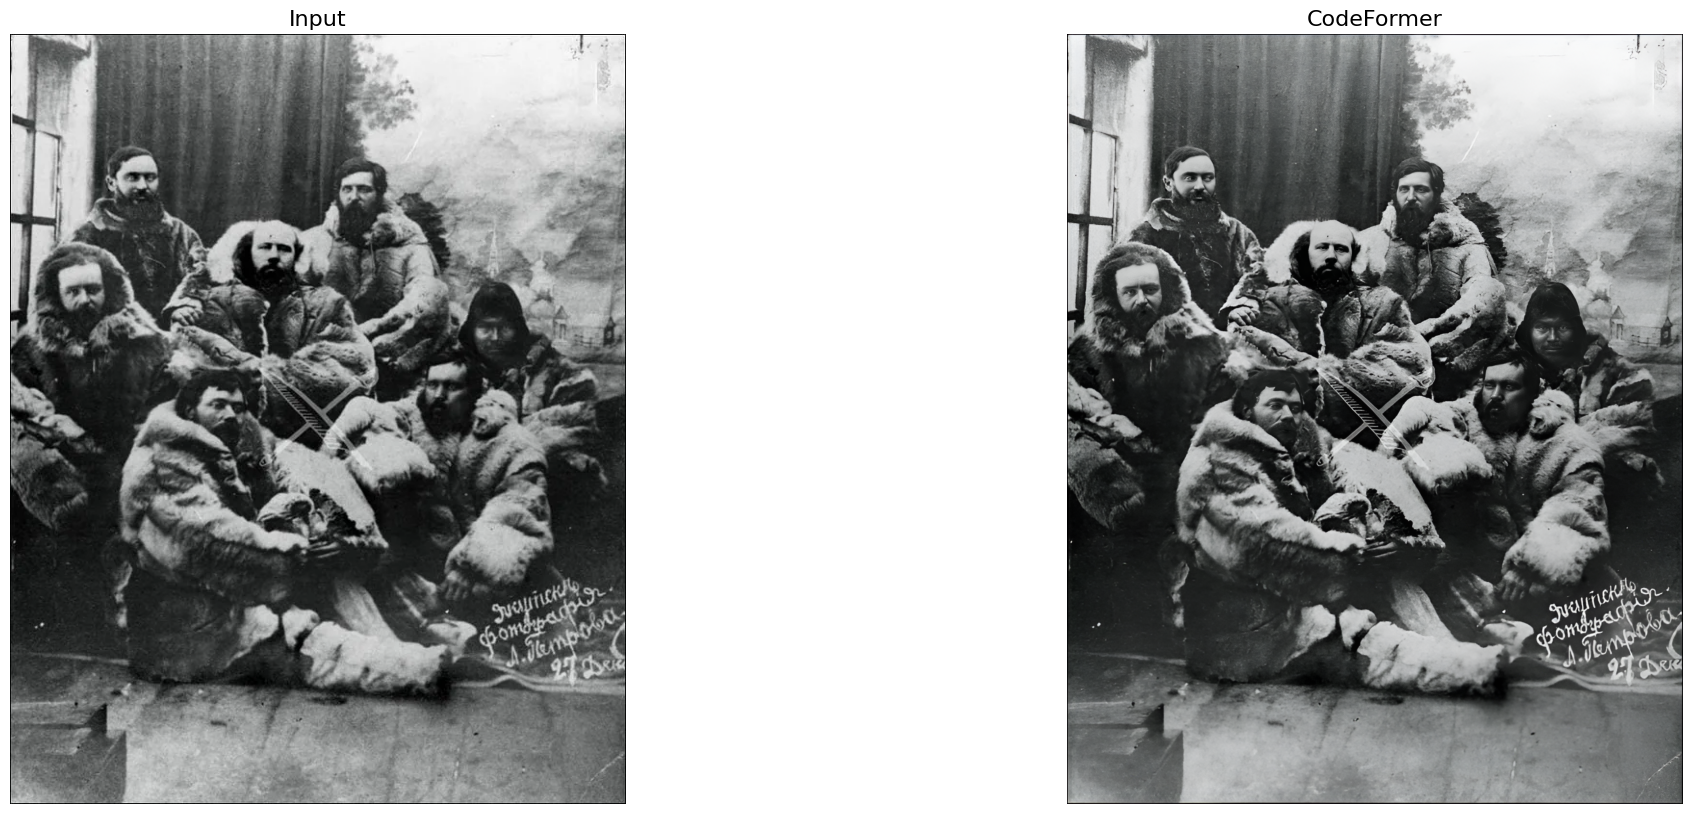

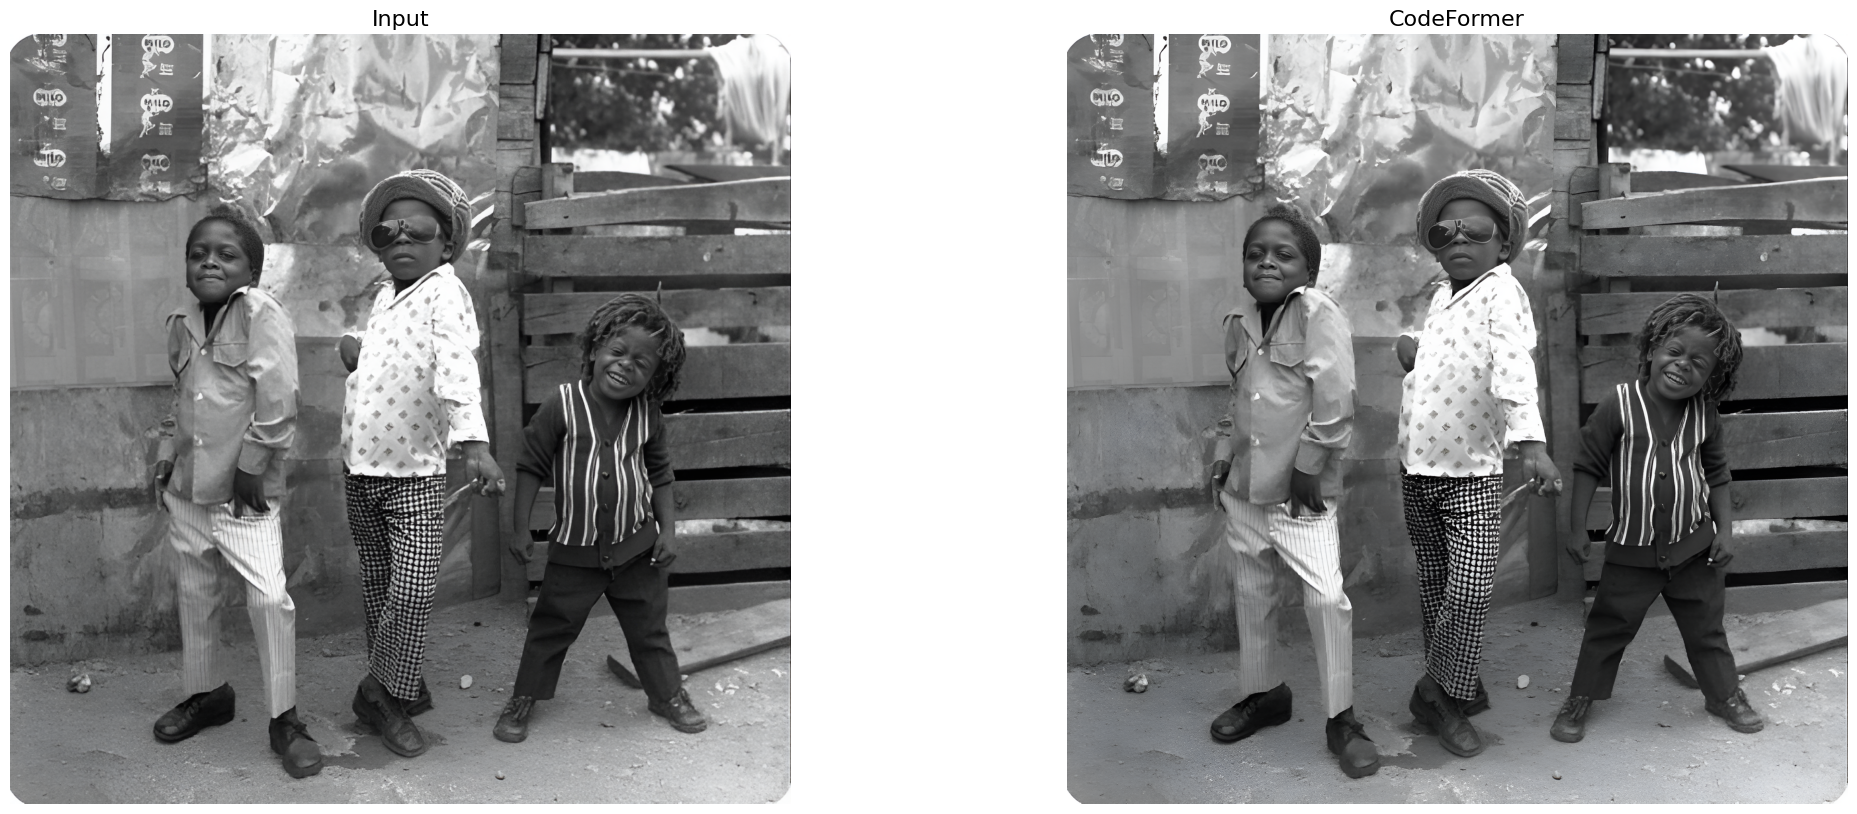

In [ ]:
#@title Visualize the results only if are images

import os
import glob

input_folder = 'inputs/user_upload'
result_folder = f'results/user_upload_{CODEFORMER_FIDELITY}/final_results'
input_list = sorted(glob.glob(os.path.join(input_folder, '*')))
for input_path in input_list:
  img_input = imread(input_path)
  basename = os.path.splitext(os.path.basename(input_path))[0]
  output_path = os.path.join(result_folder, basename+'.png')
  img_output = imread(output_path)
  display(img_input, img_output)

In [ ]:
#@title Download results
!ls results
print('Download results')
os.system(f'zip -r results.zip results/user_upload_{CODEFORMER_FIDELITY}/final_results')
try:
  files.download("results.zip")
except:
  files.download(f'/content/CodeFormer/results/{filename[:-4]}_{CODEFORMER_FIDELITY}/{filename}')

user_upload_0.7
Download results


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>